In [ ]:
%pip install openpyxl

import geocoder
import math
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from datetime import datetime
from skyfield.api import load, Topos, EarthSatellite, Star
from skyfield.data import hipparcos
import pandas as pd
import os

# --- Location ---
def get_user_location():
    print("[INFO] Requesting location permission...")
    permission = input("Do you allow access to your location? (yes/no): ").strip().lower()
    if permission != 'yes':
        print("[ERROR] Location access denied. Exiting.")
        exit()
    print("[INFO] Fetching IP-based location...")
    g = geocoder.ip('me')
    if g.ok and g.latlng:
        lat, lon = g.latlng
        address = g.city + ", " + g.country if g.city and g.country else "Unknown location"
        print(f"[INFO] Location determined: {address} ({lat}, {lon})")
        return lat, lon, address
    else:
        print("[ERROR] Could not determine location.")
        exit()

# --- Time Selection ---
def get_observation_time(ts):
    user_input = input("Enter date and time (YYYY-MM-DD HH:MM) or press Enter for now: ").strip()
    if not user_input:
        return ts.now(), "now"
    try:
        dt = datetime.strptime(user_input, "%Y-%m-%d %H:%M")
        return ts.utc(dt), dt.strftime("%Y-%m-%d_%H-%M")
    except ValueError:
        print("[ERROR] Invalid date format. Using current time.")
        return ts.now(), "now"

# --- Load Star Names ---
def load_hipparcos_names():
    if not os.path.exists('hip_name.csv.xlsx'):
        print("[WARN] hip_name.csv.xlsx file not found. Star names will be generic.")
        return pd.DataFrame(columns=['hip', 'bayer', 'con'])
    #return pd.read_csv('hip_name.csv.xlsx')
    return pd.read_excel('hip_name.csv.xlsx')

def replace_star_names_with_bayer(stars, hip_name_df):
    for obj in stars:
        if obj['type'] == 'Star' and obj['name'].startswith('Star'):
            try:
                hip_id = int(obj['name'].split()[1])
                match = hip_name_df[hip_name_df['hip'] == hip_id]
                if not match.empty:
                    row = match.iloc[0]
                    obj['name'] = f"{row['bayer']} {row['con']}"
            except Exception:
                continue
    return stars

# --- Load Constellation Lines ---
def load_constellation_lines(filepath):
    lines = []
    if not os.path.exists(filepath):
        print(f"[WARN] Constellation file not found: {filepath}")
        return lines
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 3:
                continue
            try:
                ids = list(map(int, parts[2:]))
                for i in range(0, len(ids) - 1, 2):
                    lines.append((ids[i], ids[i + 1]))
            except ValueError:
                continue
    print(f"[INFO] Loaded {len(lines)} constellation lines.")
    return lines

# --- Celestial Object Functions ---
def get_visible_planets(observer, t, eph):
    print("[INFO] Getting visible planets (incl. Sun/Moon)...")
    planet_keys = {
        'Sun': 'sun',
        'Moon': 'moon',
        'Mercury': 'mercury',
        'Venus': 'venus',
        'Mars': 'mars',
        'Jupiter': 'jupiter barycenter',
        'Saturn': 'saturn barycenter'
    }
    visible = []
    for name, key in planet_keys.items():
        try:
            planet = eph[key]
            alt, az, _ = observer.at(t).observe(planet).apparent().altaz()
            if alt.degrees > 0:
                visible.append({
                    'name': name,
                    'type': 'Planet' if name not in ['Sun', 'Moon'] else name,
                    'altitude': round(alt.degrees, 2),
                    'azimuth': round(az.degrees, 2)
                })
        except KeyError:
            continue
    print(f"[INFO] {len(visible)} planetary objects visible.")
    return visible

def get_visible_stars(observer, t):
    print("[INFO] Loading Hipparcos star catalog...")
    with load.open(hipparcos.URL) as f:
        stars = hipparcos.load_dataframe(f)
    stars = stars[stars['magnitude'] < 2.5]
    print(f"[INFO] {len(stars)} bright stars loaded.")

    visible_stars = []
    for hip_id, star in stars.iterrows():
        ra = star['ra_degrees']
        dec = star['dec_degrees']
        star_obj = Star(ra_hours=ra / 15.0, dec_degrees=dec)
        alt, az, _ = observer.at(t).observe(star_obj).apparent().altaz()
        if alt.degrees > 20:
            visible_stars.append({
                'name': f"Star {hip_id}",
                'type': 'Star',
                'altitude': round(alt.degrees, 2),
                'azimuth': round(az.degrees, 2)
            })
    print(f"[INFO] {len(visible_stars)} visible bright stars.")
    return visible_stars

def get_visible_satellites(topos, t):
    print("[INFO] Downloading satellite TLE data...")
    try:
        sats = load.tle_file('https://celestrak.org/NORAD/elements/stations.txt')
        print(f"[INFO] {len(sats)} satellites loaded.")
    except Exception as e:
        print(f"[ERROR] Failed to load satellites: {e}")
        return []
    visible = []
    for sat in sats:
        difference = sat - topos
        topocentric = difference.at(t)
        alt, az, _ = topocentric.altaz()
        if alt.degrees > 10:
            visible.append({
                'name': sat.name,
                'type': 'Satellite',
                'altitude': round(alt.degrees, 2),
                'azimuth': round(az.degrees, 2)
            })
    print(f"[INFO] {len(visible)} satellites visible.")
    return visible

# --- Image Retrieval ---
def get_object_image_url(name):
    print(f"[INFO] Searching Wikipedia image for: {name}")
    try:
        url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{name}"
        resp = requests.get(url, timeout=5)
        if resp.status_code == 200:
            data = resp.json()
            if 'thumbnail' in data and 'source' in data['thumbnail']:
                return data['thumbnail']['source']
    except requests.RequestException:
        pass
    return None

def display_image(image_url, title):
    if not image_url:
        print(f"[INFO] No image to display for {title}.")
        return
    try:
        resp = requests.get(image_url, timeout=5)
        if resp.status_code == 200:
            img = plt.imread(BytesIO(resp.content), format='jpg')
            plt.imshow(img)
            plt.axis('off')
            plt.title(title)
            plt.show()
    except requests.RequestException:
        print(f"[ERROR] Could not display image for {title}.")

# --- Sky Chart ---
def plot_sky_chart(objects, address, time_label, constellation_lines):
    print("[INFO] Plotting sky chart...")
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f"Sky Chart – {address} – {time_label}", fontsize=14)

    hip_coords = {}
    for obj in objects:
        if obj['type'] == 'Star' and 'Star' in obj['name']:
            try:
                hip_id = int(obj['name'].split()[1])
                az_rad = math.radians(obj['azimuth'])
                r = 90 - obj['altitude']
                hip_coords[hip_id] = (az_rad, r)
            except:
                continue

    for hip1, hip2 in constellation_lines:
        if hip1 in hip_coords and hip2 in hip_coords:
            az1, r1 = hip_coords[hip1]
            az2, r2 = hip_coords[hip2]
            ax.plot([az1, az2], [r1, r2], 'gray', linewidth=0.5)

    for obj in objects:
        az_rad = math.radians(obj['azimuth'])
        r = 90 - obj['altitude']
        marker = {'Planet': 'o', 'Star': '*', 'Satellite': 's', 'Sun': 'X', 'Moon': 'D'}.get(obj['type'], '.')
        ax.plot(az_rad, r, marker, label=f"{obj['name']} ({obj['type']})", markersize=6)
        ax.text(az_rad, r, obj['name'], fontsize=8, ha='center', va='bottom')

    ax.set_rlim(0, 90)
    ax.set_rlabel_position(135)
    ax.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.0))
    plt.savefig(f"sky_chart_{time_label}.png")
    plt.show()

# --- Main ---
def main():
    print("[INFO] Starting Sky Viewer...")
    lat, lon, address = get_user_location()
    ts = load.timescale()
    t, time_label = get_observation_time(ts)
    eph = load('de421.bsp')
    topos = Topos(latitude_degrees=lat, longitude_degrees=lon)
    observer = eph['earth'] + topos

    planets = get_visible_planets(observer, t, eph)
    stars = get_visible_stars(observer, t)

    hip_name_df = load_hipparcos_names()
    stars = replace_star_names_with_bayer(stars, hip_name_df)

    satellites = get_visible_satellites(topos, t)

    all_objects = planets + stars + satellites
    constellation_lines = load_constellation_lines('constellationship.fab')

    plot_sky_chart(all_objects, address, time_label, constellation_lines)

    for obj in planets:
        if obj['type'] == 'Planet':
            print(f"\n[INFO] Showing {obj['name']} (Planet)")
            print(f"Altitude: {obj['altitude']}\u00b0")
            print(f"Azimuth: {obj['azimuth']}\u00b0")
            img_url = get_object_image_url(obj['name'] + " (planet)") or get_object_image_url(obj['name'])
            display_image(img_url, obj['name'])

    print("[INFO] Program complete.")

if __name__ == "__main__":
    main()


[INFO] Starting Sky Viewer...
[INFO] Requesting location permission...
[INFO] Fetching IP-based location...
[INFO] Location determined: Hamburg, DE (53.5507, 9.993)
[INFO] Getting visible planets (incl. Sun/Moon)...
[INFO] 2 planetary objects visible.
[INFO] Loading Hipparcos star catalog...
[INFO] 93 bright stars loaded.
[INFO] 24 visible bright stars.


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [ ]:
from skyfield.api import load
from skyfield.data import hipparcos
import pandas as pd

# Load Hipparcos data
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

# Filter bright stars
bright_stars = df[df['magnitude'] < 2.5].copy()
bright_stars = bright_stars.reset_index()

# Generate mock Bayer/constellation names
def mock_bayer(ra_deg):
    if ra_deg < 90: return 'α'
    elif ra_deg < 180: return 'β'
    elif ra_deg < 270: return 'γ'
    return 'δ'

def mock_constellation(dec_deg):
    if dec_deg > 45: return 'UMa'
    elif dec_deg > 0: return 'Ori'
    elif dec_deg > -45: return 'Cen'
    return 'Cru'

bright_stars['bayer'] = bright_stars['ra_degrees'].apply(mock_bayer)
bright_stars['con'] = bright_stars['dec_degrees'].apply(mock_constellation)

# Save to Excel
output_df = bright_stars[['hip', 'bayer', 'con', 'magnitude']]
output_df.to_excel("bright_stars_bayer.xlsx", index=False)
print("Excel file created: bright_stars_bayer.xlsx")


[INFO] Starting Sky Viewer...
[INFO] Requesting location permission...
[INFO] Fetching IP-based location...
[INFO] Location determined: Hamburg, DE (53.5507, 9.993)
[INFO] Getting visible planets (incl. Sun/Moon)...
[INFO] 2 planetary objects visible.
[INFO] Loading Hipparcos star catalog...


[#################################] 100% hip_main.dat


[INFO] 93 bright stars loaded.
[INFO] 25 visible bright stars.
[WARN] hip_name.csv.xlsx file not found. Star names will be generic.
[INFO] Downloading satellite TLE data...


[#################################] 100% stations.txt


[INFO] 12 satellites loaded.
[INFO] 0 satellites visible.
[WARN] Constellation file not found: constellationship.fab
[INFO] Plotting sky chart...


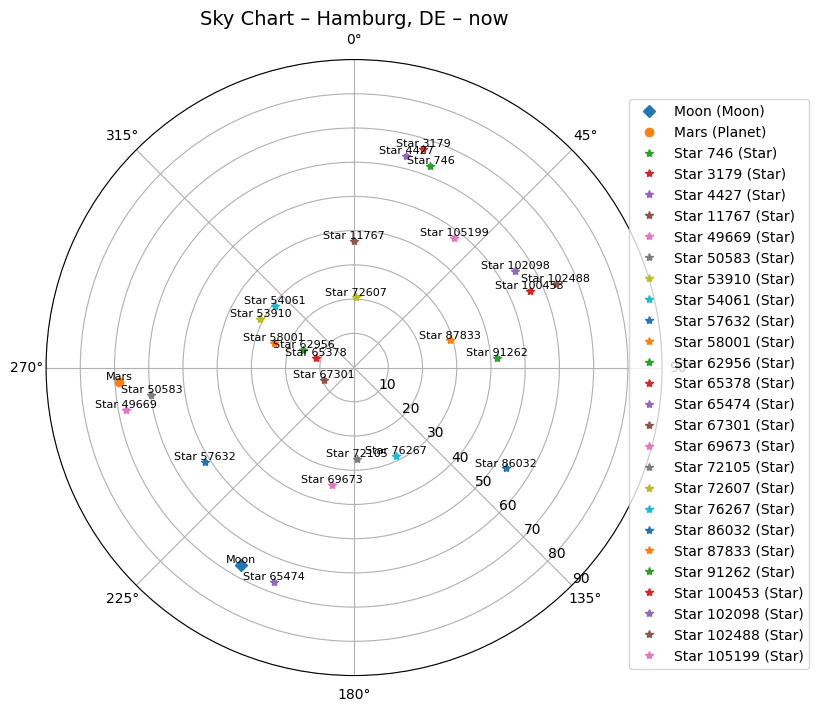


[INFO] Showing Mars (Planet)
Altitude: 21.26°
Azimuth: 266.47°
[INFO] Searching Wikipedia image for: Mars (planet)


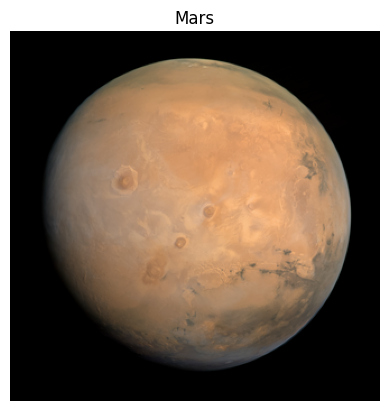

[INFO] Program complete.


In [2]:
import geocoder
import math
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from datetime import datetime
from skyfield.api import load, Topos, EarthSatellite, Star
from skyfield.data import hipparcos
import pandas as pd
import os
from collections import defaultdict

# --- Location ---
def get_user_location():
    print("[INFO] Requesting location permission...")
    permission = input("Do you allow access to your location? (yes/no): ").strip().lower()
    if permission != 'yes':
        print("[ERROR] Location access denied. Exiting.")
        exit()
    print("[INFO] Fetching IP-based location...")
    g = geocoder.ip('me')
    if g.ok and g.latlng:
        lat, lon = g.latlng
        address = g.city + ", " + g.country if g.city and g.country else "Unknown location"
        print(f"[INFO] Location determined: {address} ({lat}, {lon})")
        return lat, lon, address
    else:
        print("[ERROR] Could not determine location.")
        exit()

# --- Time Selection ---
def get_observation_time(ts):
    user_input = input("Enter date and time (YYYY-MM-DD HH:MM) or press Enter for now: ").strip()
    if not user_input:
        return ts.now(), "now"
    try:
        dt = datetime.strptime(user_input, "%Y-%m-%d %H:%M")
        return ts.utc(dt), dt.strftime("%Y-%m-%d_%H-%M")
    except ValueError:
        print("[ERROR] Invalid date format. Using current time.")
        return ts.now(), "now"

# --- Load Star Names ---
def load_hipparcos_names():
    if not os.path.exists('hip_name.csv.xlsx'):
        print("[WARN] hip_name.csv.xlsx file not found. Star names will be generic.")
        return pd.DataFrame(columns=['hip', 'bayer', 'con'])
    return pd.read_excel('hip_name.csv.xlsx')

def replace_star_names_with_bayer(stars, hip_name_df):
    for obj in stars:
        if obj['type'] == 'Star' and obj['name'].startswith('Star'):
            try:
                hip_id = int(obj['name'].split()[1])
                match = hip_name_df[hip_name_df['hip'] == hip_id]
                if not match.empty:
                    row = match.iloc[0]
                    obj['name'] = f"{row['bayer']} {row['con']}"
            except Exception:
                continue
    return stars

# --- Load Constellation Lines ---
def load_constellation_lines(filepath):
    lines = []
    if not os.path.exists(filepath):
        print(f"[WARN] Constellation file not found: {filepath}")
        return lines
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 3:
                continue
            try:
                ids = list(map(int, parts[2:]))
                for i in range(0, len(ids) - 1, 2):
                    lines.append((ids[i], ids[i + 1]))
            except ValueError:
                continue
    print(f"[INFO] Loaded {len(lines)} constellation lines.")
    return lines

# --- Label Constellations ---
def label_constellations(ax, lines, hip_coords, hip_name_df):
    constel_centers = defaultdict(list)
    for hip1, hip2 in lines:
        if hip1 in hip_coords and hip2 in hip_coords:
            az1, r1 = hip_coords[hip1]
            az2, r2 = hip_coords[hip2]
            mid_az = (az1 + az2) / 2
            mid_r = (r1 + r2) / 2
            con = hip_name_df.loc[hip_name_df['hip'] == hip1, 'con']
            if not con.empty:
                constel_centers[con.values[0]].append((mid_az, mid_r))
    for con, points in constel_centers.items():
        azs, rs = zip(*points)
        avg_az = sum(azs) / len(azs)
        avg_r = sum(rs) / len(rs)
        ax.text(avg_az, avg_r, con, fontsize=10, color='gray', ha='center', va='center', alpha=0.6)

# --- Celestial Object Functions ---
# [Functions unchanged from previous script: get_visible_planets, get_visible_stars, get_visible_satellites, get_object_image_url, display_image]

# --- Sky Chart ---
def plot_sky_chart(objects, address, time_label, constellation_lines, hip_name_df):
    print("[INFO] Plotting sky chart...")
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f"Sky Chart – {address} – {time_label}", fontsize=14)

    hip_coords = {}
    for obj in objects:
        if obj['type'] == 'Star' and 'Star' in obj['name']:
            try:
                hip_id = int(obj['name'].split()[1])
                az_rad = math.radians(obj['azimuth'])
                r = 90 - obj['altitude']
                hip_coords[hip_id] = (az_rad, r)
            except:
                continue

    for hip1, hip2 in constellation_lines:
        if hip1 in hip_coords and hip2 in hip_coords:
            az1, r1 = hip_coords[hip1]
            az2, r2 = hip_coords[hip2]
            ax.plot([az1, az2], [r1, r2], 'gray', linewidth=0.5)

    label_constellations(ax, constellation_lines, hip_coords, hip_name_df)

    for obj in objects:
        az_rad = math.radians(obj['azimuth'])
        r = 90 - obj['altitude']
        marker = {'Planet': 'o', 'Star': '*', 'Satellite': 's', 'Sun': 'X', 'Moon': 'D'}.get(obj['type'], '.')
        ax.plot(az_rad, r, marker, label=f"{obj['name']} ({obj['type']})", markersize=6)
        ax.text(az_rad, r, obj['name'], fontsize=8, ha='center', va='bottom')

    ax.set_rlim(0, 90)
    ax.set_rlabel_position(135)
    ax.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.0))
    plt.savefig(f"sky_chart_{time_label}.png")
    plt.show()

# --- Main ---
def main():
    print("[INFO] Starting Sky Viewer...")
    lat, lon, address = get_user_location()
    ts = load.timescale()
    t, time_label = get_observation_time(ts)
    eph = load('de421.bsp')
    topos = Topos(latitude_degrees=lat, longitude_degrees=lon)
    observer = eph['earth'] + topos

    planets = get_visible_planets(observer, t, eph)
    stars = get_visible_stars(observer, t)

    hip_name_df = load_hipparcos_names()
    stars = replace_star_names_with_bayer(stars, hip_name_df)

    satellites = get_visible_satellites(topos, t)

    all_objects = planets + stars + satellites
    constellation_lines = load_constellation_lines('constellationship.fab')

    plot_sky_chart(all_objects, address, time_label, constellation_lines, hip_name_df)

    for obj in planets:
        if obj['type'] == 'Planet':
            print(f"\n[INFO] Showing {obj['name']} (Planet)")
            print(f"Altitude: {obj['altitude']}\u00b0")
            print(f"Azimuth: {obj['azimuth']}\u00b0")
            img_url = get_object_image_url(obj['name'] + " (planet)") or get_object_image_url(obj['name'])
            display_image(img_url, obj['name'])

    print("[INFO] Program complete.")

if __name__ == "__main__":
    main()
